In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from pygam import GAM, s, te

import math
from functools import reduce

from sklearn import metrics
from datetime import datetime, timedelta

import warnings

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mape_std(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.std(np.abs((y_true - y_pred) / y_true)) * 100

In [2]:
# Leemos los datos de train y test
X_y_train = pd.read_csv('X_y_train.csv')
X_y_test = pd.read_csv('X_y_test.csv')


X_train = pd.DataFrame(X_y_train.iloc[:,1:13].values, columns=['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10', 'x_11'], index=pd.date_range("20180101", periods=X_y_train.iloc[:,1:13].shape[0]))
X_test = pd.DataFrame(X_y_test.iloc[:,1:13].values, columns=['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10', 'x_11'], index=pd.date_range("20190715", periods=X_y_test.iloc[:,1:13].shape[0]))

y_train = pd.Series(X_y_train.iloc[:,-1].values, name='y', index=X_train.index)
y_test = pd.Series(X_y_test.iloc[:,-1].values, name='y', index=X_test.index)


# Entrenamos el modelo con los datos de TRAIN

In [3]:
# Definimos el número de splines como 10
n_splines = 10
# Sabemos que las dos últimas variables tienen una interacción entre ellas
gam_train = GAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + te(10,11), distribution='gamma',
             link='identity', fit_intercept=True, n_splines=n_splines, max_iter=100)


In [4]:
# Definimos los lambdas
lams = np.random.rand(1000, X_train.shape[1])
lams = lams * 8 - 3
lams = np.exp(lams)

gam_kwargs = {"lam": lams, "progress": True}

# Creamos el grid search con los parámetros definidos
gam_train.gridsearch(X_train.values, y_train.values, **gam_kwargs)

100% (1000 of 1000) |####################| Elapsed Time: 0:08:34 Time:  0:08:34


GAM(callbacks=[Deviance(), Diffs()], distribution=GammaDist(), 
   fit_intercept=True, link=IdentityLink(), max_iter=100, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + te(10, 11) + intercept,
   tol=0.0001, verbose=False)

In [8]:
# Predicciones sobre TRAIN

y_pred = gam_train.predict(X_train)
MAE = metrics.mean_absolute_error(y_train, y_pred)
MAE_std = np.std(np.abs(y_train - y_pred))
MSE = metrics.mean_squared_error(y_train, y_pred)
MSE_std = np.std((y_train - y_pred) ** 2)
print("MAE:", MAE)
print("MAE_std:", MAE_std)
print("MSE:", MSE)
print("MSE_std:", MSE_std)

MAE: 0.46177913940519466
MAE_std: 0.3738387467210351
MSE: 0.3529953821397565
MSE_std: 0.5311635197798849


In [9]:
MAPE = mape(y_train, y_pred)
MAPE_std = mape_std(y_train, y_pred)
print("MAPE:", MAPE)
print("MAPE_std:", MAPE_std)

MAPE: 5.588348565618228
MAPE_std: 4.588428045371105


In [10]:
# Predicciones sobre TEST
y_pred_test = gam_train.predict(X_test)
MAE_test = metrics.mean_absolute_error(y_test, y_pred_test)
MAE_std_test = np.std(np.abs(y_test - y_pred_test))
MSE_test = metrics.mean_squared_error(y_test, y_pred_test)
MSE_std_test = np.std((y_test - y_pred_test) ** 2)

print("MAE_test:", MAE_test)
print("MAE_std_test:", MAE_std_test)
print("MSE_test:", MSE_test)
print("MSE_std_test:", MSE_std_test)

MAE_test: 0.42790520323954034
MAE_std_test: 0.31053530631027393
MSE_test: 0.27953503942468794
MSE_std_test: 0.36070664386803536


In [11]:
MAPE_test = mape(y_test, y_pred_test)
MAPE_std = mape_std(y_test, y_pred_test)
print("MAPE:", MAPE)
print("MAPE_std:", MAPE_std)

MAPE: 5.588348565618228
MAPE_std: 3.7658663607062404


In [11]:
warnings.filterwarnings('ignore')
## Partial dependence plots
gam_train.gridsearch(X_test.values, y_test.values, progress=False)


splines = [(i, term) for i, term in enumerate(gam_train.terms) if (not term.istensor and not term.isintercept)]
tensors = [(i, term) for i, term in enumerate(gam_train.terms) if (term.istensor and not term.isintercept)]

did not converge
did not converge
did not converge
did not converge


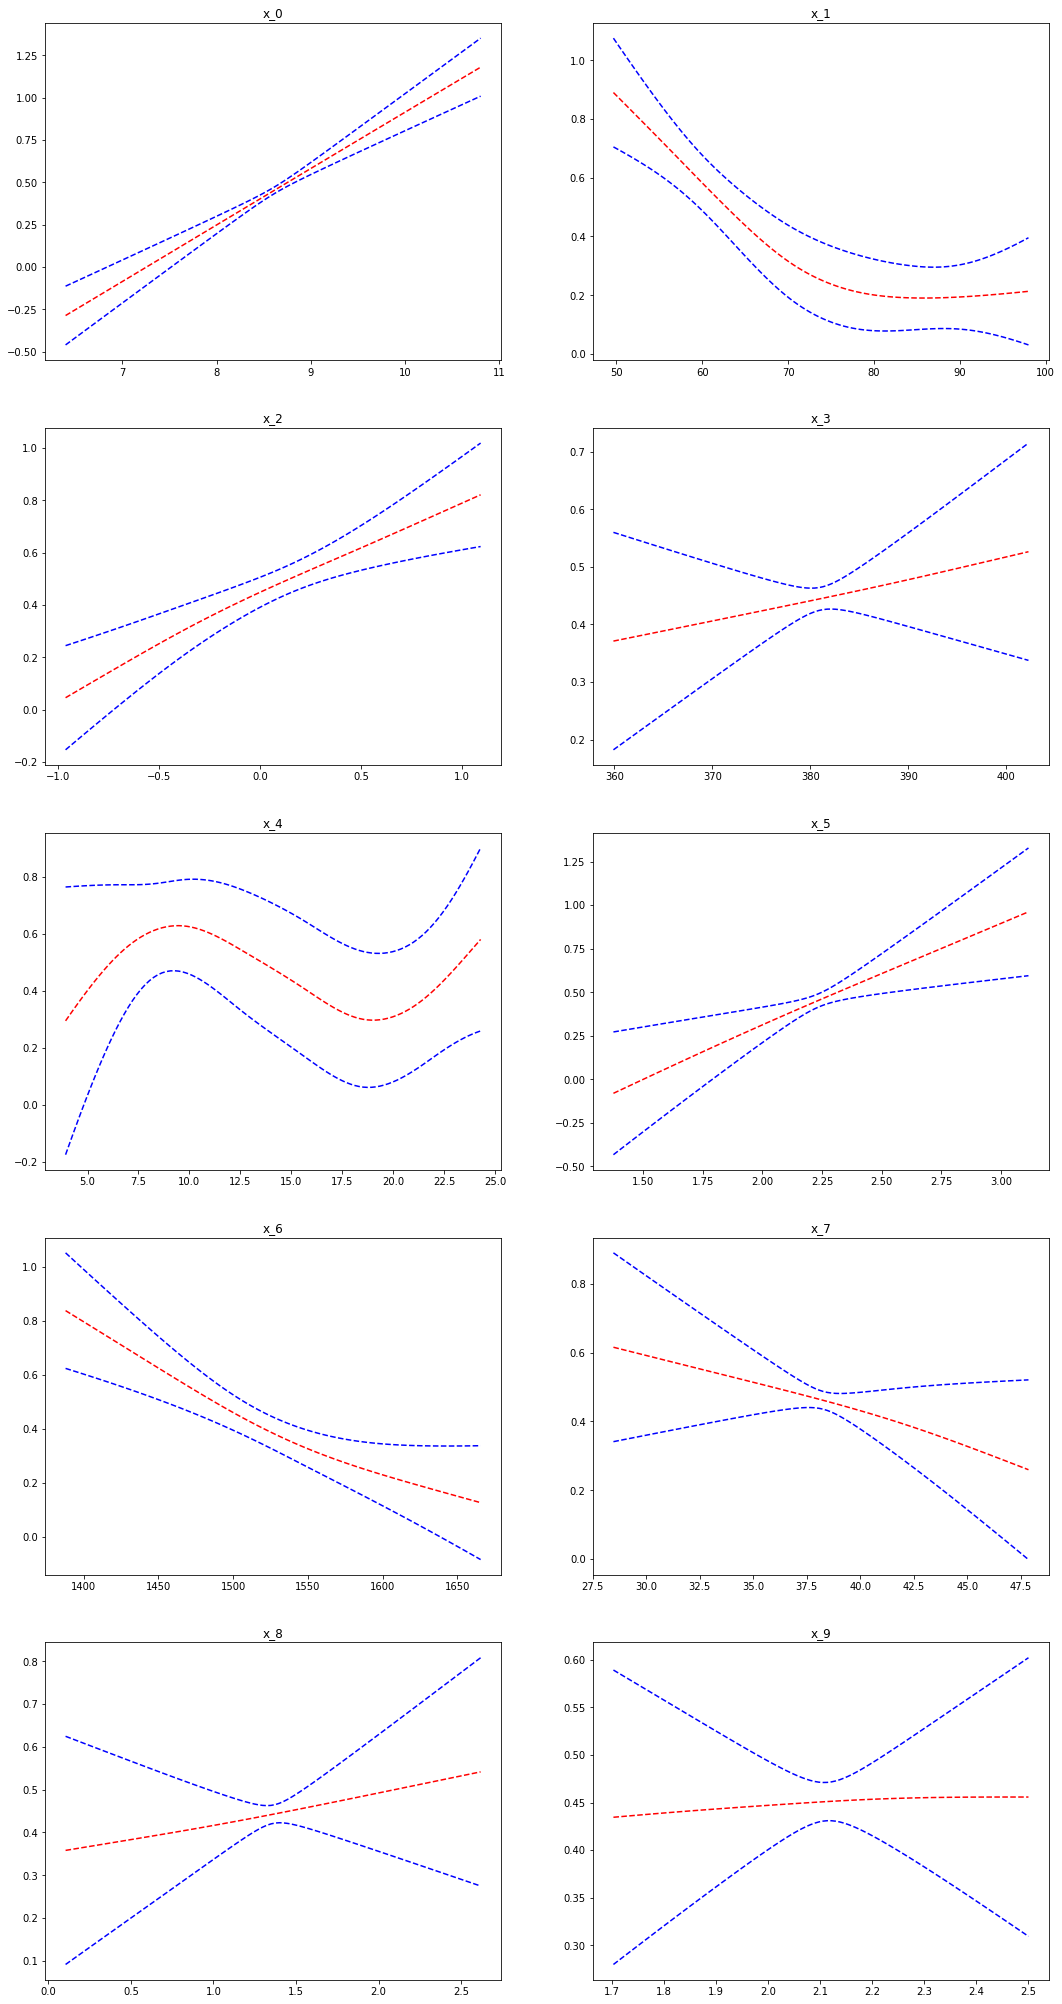

In [13]:
fig, axs = plt.subplots(math.ceil(len(splines) / 2), 2, figsize=(18,36))

# Término splines
for i, j in splines:
    XX = gam_train.generate_X_grid(term=i)

    ax = axs[i // 2][i % 2]

    ax.plot(XX[:,i], gam_train.partial_dependence(term=i, X=XX), 'r--')
    ax.plot(XX[:, i], gam_train.partial_dependence(term=i, X=XX, width=.95)[1], color='b', ls='--')
    ax.set_title(X_test.columns[i])


if len(splines) % 2 == 1:
    axs[-1][1].set_axis_off()

plt.show()


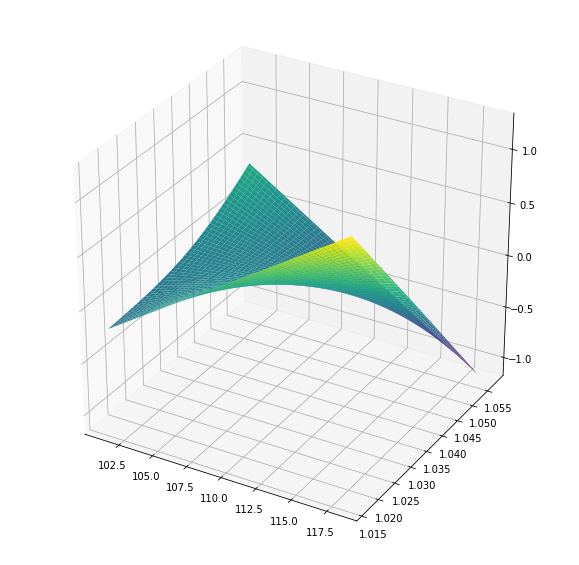

In [16]:
# Término tensor

for i, j in tensors:
    XX = gam_train.generate_X_grid(term=i, meshgrid=True)
    Z = gam_train.partial_dependence(term=i, X=XX, meshgrid=True)
    plt.figure(figsize=(10,10))
    axis = plt.axes(projection='3d')
    axis.plot_surface(XX[0], XX[1], Z, cmap='viridis')
plt.show()